In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Data Visualisation

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root= './data', train= True,download= True,transform=transform_train)
testset = torchvision.datasets.CIFAR10(root= './data', train= False,download= True,transform=transform_test)

100%|██████████| 170498071/170498071 [00:03<00:00, 47614784.94it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
num_classes = 10
batch_size = 4

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
2


In [ ]:
def imshow(img, title):
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize= (batch_size, 1))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [ ]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

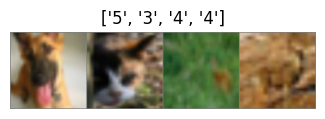

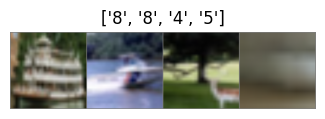

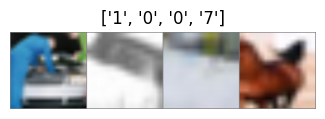

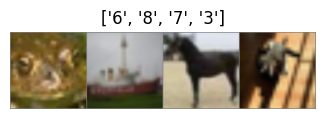

In [ ]:
for i in range(4):
    show_batch_images(trainloader)

In [ ]:
from torchvision import models

In [ ]:
vgg = models.vgg16_bn()

In [ ]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [ ]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Train CIFAR10

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr = 0.05)

Iteration: 0/3125, Loss: 2.53
Iteration: 100/3125, Loss: 3.20
Iteration: 200/3125, Loss: 2.28
Iteration: 300/3125, Loss: 2.38
Iteration: 400/3125, Loss: 2.18
Iteration: 500/3125, Loss: 2.33
Iteration: 600/3125, Loss: 2.11
Iteration: 700/3125, Loss: 2.42
Iteration: 800/3125, Loss: 2.24
Iteration: 900/3125, Loss: 2.36
Iteration: 1000/3125, Loss: 2.35
Iteration: 1100/3125, Loss: 2.44
Iteration: 1200/3125, Loss: 1.96
Iteration: 1300/3125, Loss: 2.30
Iteration: 1400/3125, Loss: 2.21
Iteration: 1500/3125, Loss: 2.23
Iteration: 1600/3125, Loss: 2.33
Iteration: 1700/3125, Loss: 2.25
Iteration: 1800/3125, Loss: 1.84
Iteration: 1900/3125, Loss: 2.32
Iteration: 2000/3125, Loss: 2.11
Iteration: 2100/3125, Loss: 2.30
Iteration: 2200/3125, Loss: 2.08
Iteration: 2300/3125, Loss: 2.09
Iteration: 2400/3125, Loss: 2.11
Iteration: 2500/3125, Loss: 2.05
Iteration: 2600/3125, Loss: 2.55
Iteration: 2700/3125, Loss: 2.06
Iteration: 2800/3125, Loss: 2.03
Iteration: 2900/3125, Loss: 1.92
Iteration: 3000/3125, 

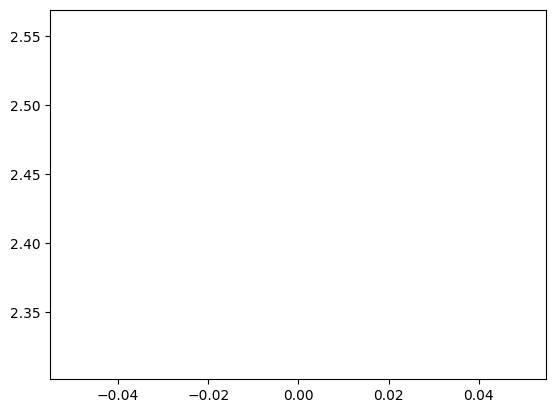

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/ batch_size)


for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))


plt.plot(loss_epoch_arr)
plt.show()

### Freezing layers

In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [ ]:
vgg.classifier = nn.Sequential(*mod_classifier)

In [ ]:
for param in vgg.parameters():
    param.requires_grad = False

In [ ]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [ ]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 4096])
torch.Size([10])


In [ ]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr= 0.05)

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/ batch_size)


for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))


plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.28
Iteration: 100/3125, Loss: 2.07
Iteration: 200/3125, Loss: 1.67
Iteration: 300/3125, Loss: 1.09
Iteration: 400/3125, Loss: 1.43
Iteration: 500/3125, Loss: 1.17
Iteration: 600/3125, Loss: 1.71
Iteration: 700/3125, Loss: 2.27
Iteration: 800/3125, Loss: 1.38
Iteration: 900/3125, Loss: 2.30
Iteration: 1000/3125, Loss: 2.14
Iteration: 1100/3125, Loss: 1.34
Iteration: 1200/3125, Loss: 2.17
Iteration: 1300/3125, Loss: 2.21
Iteration: 1400/3125, Loss: 1.58
Iteration: 1500/3125, Loss: 1.94
Iteration: 1600/3125, Loss: 2.48
Iteration: 1700/3125, Loss: 1.77
Iteration: 1800/3125, Loss: 2.23
Iteration: 1900/3125, Loss: 3.48
Iteration: 2000/3125, Loss: 2.23
Iteration: 2100/3125, Loss: 1.84
Iteration: 2200/3125, Loss: 2.30
Iteration: 2300/3125, Loss: 2.42
Iteration: 2400/3125, Loss: 1.91
Iteration: 2500/3125, Loss: 2.10
Iteration: 2600/3125, Loss: 1.88


KeyboardInterrupt: ignored

### Storing models

In [ ]:
import copy

In [ ]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/ batch_size)
min_loss = 1000

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
          min_loss = loss.item()
          best_model = copy.deepcopy(vgg.state_dict())
          print("Min loss %0.2f" % min_loss)

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch, max_epochs, evaluation(testloader, vgg), evaluation(trainloader, vgg)))


plt.plot(loss_epoch_arr)
plt.show()

Min loss 2.56
Iteration: 0/3125, Loss: 2.56
Min loss 1.93
Min loss 1.61
Min loss 1.59
Min loss 0.93
Iteration: 100/3125, Loss: 1.75
Min loss 0.86
Iteration: 200/3125, Loss: 1.17
Min loss 0.68
Iteration: 300/3125, Loss: 2.37
Iteration: 400/3125, Loss: 2.37
Iteration: 500/3125, Loss: 1.81
Iteration: 600/3125, Loss: 1.04
Min loss 0.64
Iteration: 700/3125, Loss: 1.75
Iteration: 800/3125, Loss: 1.68
Iteration: 900/3125, Loss: 2.66
Iteration: 1000/3125, Loss: 1.37
Iteration: 1100/3125, Loss: 2.36
Iteration: 1200/3125, Loss: 2.78
Iteration: 1300/3125, Loss: 2.35
Iteration: 1400/3125, Loss: 1.69
Iteration: 1500/3125, Loss: 4.47
Iteration: 1600/3125, Loss: 1.50
Iteration: 1700/3125, Loss: 1.95
Iteration: 1800/3125, Loss: 2.61


KeyboardInterrupt: ignored

In [ ]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

### ResNet

In [ ]:
resnet = models.resnet18(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 252MB/s]


In [ ]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for param in resnet.parameters():
    param.requires_grad = False

In [ ]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


In [ ]:
resnet = resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr = 0.01)

Min loss 1.84
Iteration: 0/3125, Loss: 1.84
Min loss 1.47
Min loss 1.23
Min loss 1.19
Min loss 1.12
Min loss 1.08
Min loss 0.79
Min loss 0.43
Iteration: 100/3125, Loss: 1.35
Iteration: 200/3125, Loss: 0.90
Iteration: 300/3125, Loss: 0.90
Iteration: 400/3125, Loss: 0.75
Iteration: 500/3125, Loss: 1.20
Iteration: 600/3125, Loss: 1.73
Min loss 0.43
Iteration: 700/3125, Loss: 1.03
Min loss 0.41
Iteration: 800/3125, Loss: 1.43
Iteration: 900/3125, Loss: 1.10
Iteration: 1000/3125, Loss: 1.20
Min loss 0.34
Iteration: 1100/3125, Loss: 1.34
Iteration: 1200/3125, Loss: 1.24
Iteration: 1300/3125, Loss: 1.71
Iteration: 1400/3125, Loss: 0.72
Iteration: 1500/3125, Loss: 1.06
Iteration: 1600/3125, Loss: 1.24
Iteration: 1700/3125, Loss: 1.84
Iteration: 1800/3125, Loss: 1.22
Iteration: 1900/3125, Loss: 1.66
Iteration: 2000/3125, Loss: 1.13
Iteration: 2100/3125, Loss: 1.16
Iteration: 2200/3125, Loss: 1.65
Iteration: 2300/3125, Loss: 1.26
Iteration: 2400/3125, Loss: 0.75
Iteration: 2500/3125, Loss: 0.94


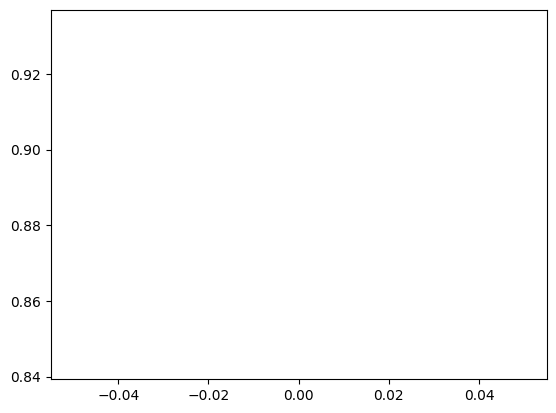

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/ batch_size)


for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()

        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(resnet.state_dict())
            print("Min loss %0.2f" % min_loss)

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch, max_epochs, evaluation(testloader, resnet), evaluation(trainloader, resnet)))


plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
resnet.load_state_dict(best_model)
print(evaluation(trainloader, resnet), evaluation(testloader, resnet))

57.426 56.45


### Inception Model

In [ ]:
inception = models.inception_v3(pretrained = True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 56.6MB/s]


In [ ]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
for param in inception.parameters():
    param.requires_grad = False

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])


In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root= './data', train= True,download= True,transform=transform_train)
testset = torchvision.datasets.CIFAR10(root= './data', train= False,download= True,transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 16
trainloader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=True)

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.01)

In [ ]:
def evaluation_inception(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, aux_outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

Min loss 2.31
Iteration: 0/3125, Loss: 2.31
Min loss 1.76
Min loss 1.47
Min loss 1.22
Min loss 1.18
Iteration: 100/3125, Loss: 1.89
Min loss 1.09
Iteration: 200/3125, Loss: 1.97
Iteration: 300/3125, Loss: 1.57
Iteration: 400/3125, Loss: 1.84
Iteration: 500/3125, Loss: 2.13
Iteration: 600/3125, Loss: 1.72
Iteration: 700/3125, Loss: 1.78
Iteration: 800/3125, Loss: 2.06
Iteration: 900/3125, Loss: 1.75
Iteration: 1000/3125, Loss: 2.39
Min loss 0.99
Iteration: 1100/3125, Loss: 1.97
Iteration: 1200/3125, Loss: 2.09
Iteration: 1300/3125, Loss: 1.98
Iteration: 1400/3125, Loss: 2.29
Min loss 0.89
Iteration: 1500/3125, Loss: 2.00
Iteration: 1600/3125, Loss: 1.86
Iteration: 1700/3125, Loss: 2.28
Iteration: 1800/3125, Loss: 1.72
Iteration: 1900/3125, Loss: 1.74
Iteration: 2000/3125, Loss: 2.05
Iteration: 2100/3125, Loss: 1.82
Iteration: 2200/3125, Loss: 1.84
Iteration: 2300/3125, Loss: 2.28
Iteration: 2400/3125, Loss: 2.01
Iteration: 2500/3125, Loss: 2.76
Iteration: 2600/3125, Loss: 1.86
Iteration

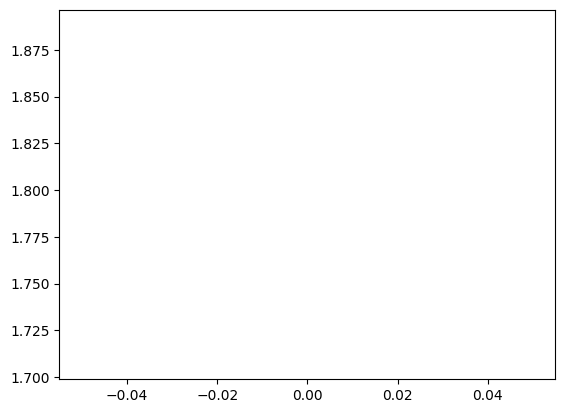

In [ ]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/ batch_size)


for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        opt.zero_grad()

        outputs, aux_outputs = inception(inputs)
        loss = loss_fn(outputs, labels) + 0.3 * loss_fn(aux_outputs, labels)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(inception.state_dict())
            print("Min loss %0.2f" % min_loss)

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        if i % 100 == 0:
            print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))
    
    loss_epoch_arr.append(loss.item())
    print("Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f" % (epoch, max_epochs, evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception)))


plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

47.908 48.35
